In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, gridspec, ticker
import matplotlib.colors
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import EngFormatter
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd
import seaborn as sns
import bioframe as bf
import bbi
import cooler
import cooltools
from cooltools.sandbox.expected_smoothing import log_smooth
from coolpuppy import coolpup
from coolpuppy.lib.numutils import get_enrichment
from pybedtools import BedTool as pbt
import networkx as nx
from scipy.stats import wilcoxon, gaussian_kde
from scipy.interpolate import interpn
from sklearn.linear_model import LinearRegression
import pycircos
import collections
import utils
import re
from adjustText import adjust_text


# Matplotlib settings
mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=2)
mpl.rc('xtick.minor', width=0.4, size=1)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=2)
mpl.rc('ytick.minor', width=0.4, size=1)

colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}

# Input data to run this notebook

In [2]:
"""In this notebook we use our Hi-C data combined with Hi-C 
from Hu et al., 2021: https://doi.org/10.1038/s41467-021-24243-0
Thus, to reproduce figures from the manuscript, one has to create
mcool files from Hu2021 raw data and then merge it with mcools
from this study.

Still, one can use the Hi-C from this study without Hu2021 data
and get similar (but not identical) results.
"""

clr_path = {
    'NeuN+': "../../NeuNplus.our_and_Hu2021_merged.mcool",
    'NeuN-': "../../NeuNminus.our_and_Hu2021_merged.mcool"
}
cts = list(clr_path.keys()) # cell types

neuronal_dot_anchor_path = "../data/Suppl. Table S2. Neuronal dot anchors.xlsx"

# These files can be obtained by running fithic.ipynb
fithic_path = {
    'NeuN+': "../data/neuronal_dots.NeuN+.bedpe.gz",
    'NeuN-': "../data/non-neuronal_dots.bedpe.gz",
}

# Expression data obtained by reanalyzing the dataset
# from Rizzardi et al., 2019: https://doi.org/10.1038%2Fs41593-018-0297-8
# Counts are log2(TPM+1)
riz_cnts_path = '../data/rizzardi.log2TPM_counts.tsv.gz'
riz_deseq2_res_path = '../data/rizzardi.DEseq2_results.tsv.gz'

# List of Housekeeping genes obtained from
# HRT Atlas v1.0 database: https://doi.org/10.1093/nar/gkaa609
hk_gene_path = "../data/Housekeeping_GenesHuman.csv.gz"

# List of human transcription factors obtained from
# Lambert et al., 2018: https://doi.org/10.1016/j.cell.2018.01.029
human_tf_path = "../data/lambert2018.TFs.DatabaseExtract_v_1.01.csv.gz"

# LaminB1 data obtained from Ahanger et al., 2021:
# https://doi.org/10.1038/s41593-021-00879-5
lamin_peak_path = "../data/GW20_Cortex_LaminB_peaks_clean.bed.gz"
lamin_profile_path = "../data/GW20_Cortex_LaminB_Rep1.bw"

# Plot: Example of a Hi-C map with polycomb interactions (Figure 4A)

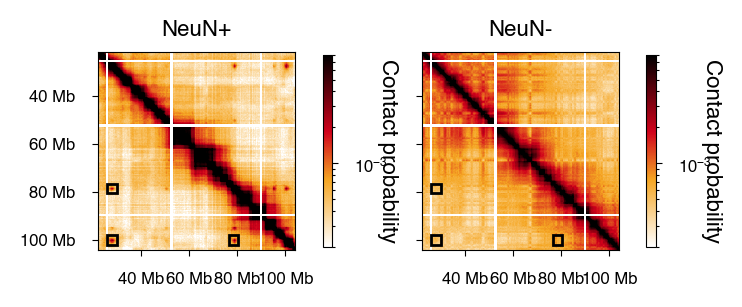

In [3]:
## Plot zoom-out
res = 200_000 # Hi-C resolution
clrs = {ct: cooler.Cooler(clr_path[ct] + f'::resolutions/{res}') 
        for ct in cts}

# Select snips to zoom-in
snips = [[['chr13', 76_500_000, 80_500_000],  ['chr13', 26_000_000, 30_000_000]], 
         [['chr13', 98_000_000, 102_000_000], ['chr13', 26_000_000, 30_000_000]], 
         [['chr13', 98_000_000, 102_000_000], ['chr13', 76_500_000, 80_500_000]]]

# Draw heatmaps
f, axs = plt.subplots(1, 2, dpi=200, figsize=(3.6, 2), sharey=True, constrained_layout=True)

for i, ct in enumerate(cts):
    utils.plot_hic_reg_zoom_out(
        clrs[ct], 
        reg=('chr13', 22_000_000, 104_000_000), 
        ax=axs[i], vmin=0.0002, vmax=0.008, 
        snips=snips, title=ct
    )

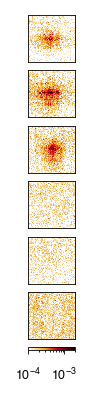

In [4]:
# Plot zoom-in
res = 50_000
clrs = {ct: cooler.Cooler(clr_path[ct] + f'::resolutions/{res}') 
        for ct in ('NeuN+', 'NeuN-')}

# Plot
f, axs = plt.subplots(2*len(snips)+1, 1, dpi=150, figsize=(0.9, 2.9),
                      gridspec_kw={'height_ratios': [1, 1, 1, 1, 1, 1, 0.05]})

for j, (reg1, reg2) in enumerate(snips):
    for i, ct in enumerate(['NeuN+', 'NeuN-']):
        ax = axs[len(snips)*i+j]
        im = utils.plot_hic_reg_zoom_in(
            clrs[ct], reg1, reg2, 
            ax, vmin=0.0001, vmax=0.002
        )

# Colorbar
axs[2*len(snips)].set_box_aspect(1/20)
plt.colorbar(im, cax=axs[2*len(snips)], orientation='horizontal');

# Plot: average neuronal dot (Figure 4B)

In [5]:
# Load hi-c matrices
res = 10_000
clrs = {ct: cooler.Cooler(clr_path[ct] + f'::resolutions/{res}') 
        for ct in cts}

In [6]:
# Load peaks and merge
dot_anch = pd.read_excel(neuronal_dot_anchor_path, na_values='-', skiprows=2)

dot_anch.loc[:, 'mid_start'] = (dot_anch['start'] + dot_anch['end']) / 2 \
    - ((dot_anch['start'] + dot_anch['end']) / 2) % res
dot_anch.loc[:, 'mid_end'] = dot_anch['mid_start'] + res
dot_anch.loc[:, 'mid_start'] = dot_anch.loc[:, 'mid_start'].astype(int)
dot_anch.loc[:, 'mid_end'] = dot_anch.loc[:, 'mid_end'].astype(int)
dot_anch.head()

/tmp/ipykernel_459022/3779834246.py:7: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dot_anch.loc[:, 'mid_start'] = dot_anch.loc[:, 'mid_start'].astype(int)
/tmp/ipykernel_459022/3779834246.py:8: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dot_anch.loc[:, 'mid_end'] = dot_anch.loc[:, 'mid_end'].astype(int)


,chrom,start,end,genes,mid_start,mid_end
0,chr1,18630000,18640000,PAX7,18630000,18640000
1,chr1,24930000,24940000,RUNX3,24930000,24940000
2,chr1,44410000,44420000,RNF220,44410000,44420000
3,chr1,46480000,46490000,DMBX1,46480000,46490000
4,chr1,47230000,47240000,"TAL1,AL135960.1",47230000,47240000


In [7]:
# CIS expected
cvd_10 = {}

for ct in cts:
    print(ct)
    cvd_10[ct] = cooltools.expected_cis(
        clrs[ct],
        smooth=False,
        nproc=10
    )

NeuN+
NeuN-


In [8]:
# TRANS expected
trans_cvd_10 = {}

for ct in cts:
    print(ct)
    trans_cvd_10[ct] = cooltools.expected_trans(
        clrs[ct],
        nproc=10
    )

NeuN+
NeuN-


In [9]:
# Split by distance
nproc=10
pup_hand = {ct: {} for ct in cts}

for ct in cts:
    print(ct)
    pup_hand[ct]['short'] = coolpup.pileup(
        clrs[ct], 
        dot_anch,
        expected_df=cvd_10[ct],
        flank=150000,
        mindist=3*res,
        maxdist=int(3e6),
        nproc=nproc
    );
    pup_hand[ct]['long'] = coolpup.pileup(
        clrs[ct], 
        dot_anch,
        expected_df=cvd_10[ct],
        flank=150000,
        mindist=int(3e6),
        nproc=nproc
    );
    pup_hand[ct]['trans'] = coolpup.pileup(
        clrs[ct], 
        dot_anch,
        expected_df=trans_cvd_10[ct],
        flank=150000,
        trans=True,
        nproc=nproc
    );

NeuN+


INFO:coolpuppy:('chr11', 'chr11'): 3
INFO:coolpuppy:('chr10', 'chr10'): 16
INFO:coolpuppy:('chr7', 'chr7'): 8
INFO:coolpuppy:('chr8', 'chr8'): 1
INFO:coolpuppy:('chr5', 'chr5'): 5
INFO:coolpuppy:('chr6', 'chr6'): 7
INFO:coolpuppy:('chr1', 'chr1'): 13
INFO:coolpuppy:('chr15', 'chr15'): 1
INFO:coolpuppy:('chr14', 'chr14'): 6
INFO:coolpuppy:('chr4', 'chr4'): 6
INFO:coolpuppy:('chr13', 'chr13'): 2
INFO:coolpuppy:('chr3', 'chr3'): 2
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr20', 'chr20'): 1
INFO:coolpuppy:('chr12', 'chr12'): 3
INFO:coolpuppy:('chr18', 'chr18'): 1
INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:('chrX', 'chrX'): 2
INFO:coolpuppy:Total number of piled up windows: 91
INFO:coolpuppy:('chr9', 'chr9'): 66
INFO:coolpuppy:('chr10', 'chr10'): 120
INFO:coolpuppy:('chr7', 'chr7'): 58
INFO:coolpuppy:('chr8', 'chr8'): 27
INFO:coolpuppy:('chr5', 'chr5'): 131
INFO:coolpuppy:('chr6', 'chr6'): 98
INFO

NeuN-


INFO:coolpuppy:('chr11', 'chr11'): 3
INFO:coolpuppy:('chr10', 'chr10'): 16
INFO:coolpuppy:('chr8', 'chr8'): 1
INFO:coolpuppy:('chr7', 'chr7'): 8
INFO:coolpuppy:('chr6', 'chr6'): 7
INFO:coolpuppy:('chr14', 'chr14'): 6
INFO:coolpuppy:('chr5', 'chr5'): 5
INFO:coolpuppy:('chr15', 'chr15'): 1
INFO:coolpuppy:('chr13', 'chr13'): 2
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr1', 'chr1'): 13
INFO:coolpuppy:('chr4', 'chr4'): 6
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr18', 'chr18'): 1
INFO:coolpuppy:('chr20', 'chr20'): 1
INFO:coolpuppy:('chr3', 'chr3'): 2
INFO:coolpuppy:('chr12', 'chr12'): 3
INFO:coolpuppy:('chrX', 'chrX'): 2
INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:Total number of piled up windows: 91
INFO:coolpuppy:('chr9', 'chr9'): 66
INFO:coolpuppy:('chr8', 'chr8'): 27
INFO:coolpuppy:('chr10', 'chr10'): 120
INFO:coolpuppy:('chr7', 'chr7'): 58
INFO:coolpuppy:('chr5', 'chr5'): 131
INFO:coolpuppy:('chr1', 'chr1'): 218
INF

In [10]:
# Save pup_dong
# for hic_ct in ["NeuN+", "NeuN-"]:
#     for k27_ct in ['NeuN+', 'NeuN-']:
#         for grp in ['short', 'long', 'trans']:
#             np.save(f"pup_dong.hic-{hic_ct}.k27-{k27_ct}.grp-{grp}.npy", pup_dong[hic_ct][k27_ct][grp]['data'][0])

In [11]:
# # Read pup_dong
# for hic_ct in ["NeuN+", "NeuN-"]:
#     for k27_ct in ['NeuN+', 'NeuN-']:
#         for grp in ['short', 'long', 'trans']:
#             pup_dong[hic_ct][k27_ct][grp] = np.load(f"pup_dong.hic-{hic_ct}.k27-{k27_ct}.grp-{grp}.npy", 
#                                                     allow_pickle=True)

Text(0.5, 0, 'Distance from\nH3K27me3 peak')

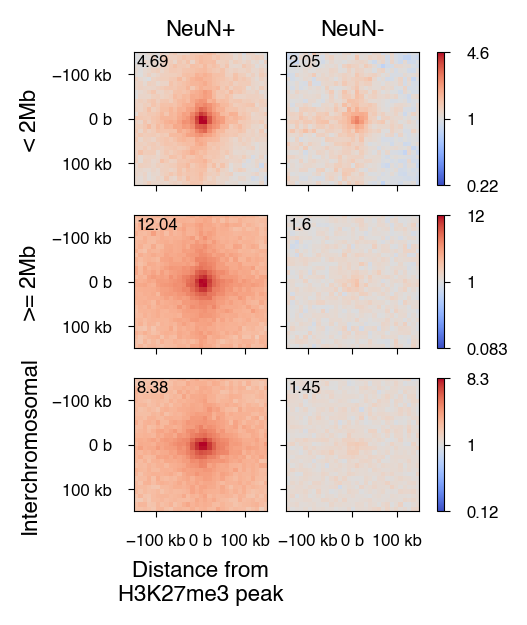

In [12]:
# Plot data for each ct separately
bp_formatter = EngFormatter('b')


def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1e5))
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1e5))
        ax.xaxis.tick_bottom()
        
        
nrows, ncols = 3, 2
fig, axs = plt.subplots(nrows, ncols+1, dpi=200, figsize=(2, 3),
                        gridspec_kw={'width_ratios': [1, 1, 0.05]})

vmax = {'short': 4.6, 'long': 12, 'trans': 8.3}
vmin = {k: 1/val for k, val in vmax.items()}
pup_grps = ['short', 'long', 'trans']

for i, pup in enumerate(pup_grps):
    for j, ct in enumerate(cts):
        arr = pup_hand[ct][pup]['data'][0]
        im = axs[i, j].imshow(
            arr, 
            cmap='coolwarm',
            norm=LogNorm(vmax=vmax[pup], vmin=vmin[pup]),
            extent=(-150000, 150000, 150000, -150000)
        )
        # Enrichment
        en = get_enrichment(arr, 0)
        axs[i, j].text(0.02, 0.98, round(en, 2), va='top', 
                       transform=axs[i, j].transAxes, fontsize=6)
        format_ticks(axs[i, j])
    
    # Colorbar
    plt.colorbar(im, cax=axs[i, ncols], ticks=[vmin[pup], 1, vmax[pup]], 
                 format=ticker.FuncFormatter(lambda x, pos: f"{x:.2g}"))
    axs[i, ncols].set_box_aspect(20)
    axs[i, ncols].minorticks_off()

# Ticks
for i in range(3):
    axs[i, 1].yaxis.set_ticklabels([])
for i, j in [[0, 0], [0, 1], [1, 0], [1, 1]]:
    axs[i, j].xaxis.set_ticklabels([])
    
# Labels
axs[0, 0].set_title(cts[0])
axs[0, 1].set_title(cts[1])
axs[0, 0].set_ylabel('< 2Mb')
axs[1, 0].set_ylabel('>= 2Mb')
axs[2, 0].set_ylabel('Interchromosomal')
axs[2, 0].set_xlabel('Distance from\nH3K27me3 peak')

# Plots for neuronal dot anchors

In [13]:
# Read Supp.Table with neuronal dot annotation
dot_anch = pd.read_excel(neuronal_dot_anchor_path, na_values='-', skiprows=2)
dot_anch.head()

,chrom,start,end,genes
0,chr1,18630000,18640000,PAX7
1,chr1,24930000,24940000,RUNX3
2,chr1,44410000,44420000,RNF220
3,chr1,46480000,46490000,DMBX1
4,chr1,47230000,47240000,"TAL1,AL135960.1"


In [14]:
# Extract gene names
hand_genes_all = dot_anch['genes'].dropna().str.split(',').values
hand_genes_all = [item for sublist in hand_genes_all for item in sublist]

# remove ncRNAs
regex = re.compile(r'(^LINC|^RNA|^MIR|^A[LCP][0-9]+|.*\-AS|.*\-DT|.*\-OT)')
hand_pc = [i for i in hand_genes_all if not regex.match(i)]
hand_pc[:5]

['PAX7', 'RUNX3', 'RNF220', 'DMBX1', 'TAL1']

## Plot: polycomb gene expression vs housekeeping (Figure 4H)

In [15]:
# Get expression of genes within neuronal dot anchors
riz_cnts = pd.read_table(riz_cnts_path)
hand_pc_cnts = riz_cnts.loc[(riz_cnts['gene.name'].isin(hand_pc)) & 
                            (riz_cnts['gene.type'] == 'protein_coding')]

# Add info about differentially expressed genes
riz_deseq_res = pd.read_table(
    riz_deseq2_res_path, usecols=['gene', 'log2FoldChange', 'padj'])\
    .rename(columns={'log2FoldChange': 'log2FC'})
hand_pc_cnts = hand_pc_cnts\
    .merge(riz_deseq_res, left_on='gene.id', right_on='gene', how='inner')\
    .drop(columns='gene')

hand_pc_cnts.head()

,chrom,start,end,gene.name,strand,gene.id,gene.type,log2TPM_NeuNplus,log2TPM_NeuNminus,log2FC,padj
0,chrX,25003693,25016420,ARX,-,ENSG00000004848,protein_coding,5.669002,4.901866,0.602913,2.442785e-02
1,chr7,27181156,27185232,HOXA11,-,ENSG00000005073,protein_coding,0.000000,0.118441,-0.200278,NaN
2,chr17,48026166,48038030,COPZ2,-,ENSG00000005243,protein_coding,0.405034,2.557535,-3.953741,9.463418e-07
3,chr7,97005552,97011040,DLX6,+,ENSG00000006377,protein_coding,3.610105,0.593000,4.173928,1.990013e-08
4,chr11,31784778,31817961,PAX6,-,ENSG00000007372,protein_coding,1.051399,5.202118,-5.069118,3.536519e-53


In [16]:
# Load housekeeping genes
hk_gene = pd.read_table(hk_gene_path, sep=';')[['Gene.name']]
hk_cnts = riz_cnts.merge(hk_gene, left_on='gene.name', right_on='Gene.name')
hk_cnts.head()

,chrom,start,end,gene.name,strand,gene.id,gene.type,log2TPM_NeuNplus,log2TPM_NeuNminus,Gene.name
0,chr20,50934866,50959140,DPM1,-,ENSG00000000419,protein_coding,3.425938,3.225108,DPM1
1,chr11,64269829,64284704,BAD,-,ENSG00000002330,protein_coding,3.257597,2.664406,BAD
2,chrX,2691186,2741309,CD99,+,ENSG00000002586,protein_coding,0.145482,1.479318,CD99
3,chr17,38869858,38921770,LASP1,+,ENSG00000002834,protein_coding,4.067405,3.442796,LASP1
4,chr12,8940360,8949761,M6PR,-,ENSG00000003056,protein_coding,5.130813,4.407837,M6PR


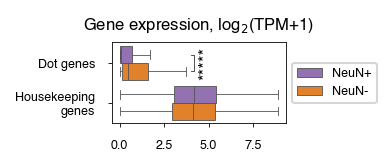

In [17]:
# Plot
def annot(y_mid, x, h, sig): 
    y1, y2 = y_mid-0.2, y_mid+0.2
    col = 'k'
    plt.plot([x, x+h, x+h, x], [y1, y1, y2, y2], lw=0.4, c=col, alpha=0.8)
    plt.text(x+h+0.2, (y1+y2)*.5, sig, ha='left', va='center', color=col, rotation='vertical')
    

hand_pc_cnts_plot = hand_pc_cnts.copy(deep=True)
hand_pc_cnts_plot['grp'] = 'Dot genes'
hk_cnts['grp'] = 'Housekeeping\ngenes'
plot_df = pd.concat([hand_pc_cnts_plot[['log2TPM_NeuNplus', 'log2TPM_NeuNminus', 'grp']], 
                     hk_cnts[['log2TPM_NeuNplus', 'log2TPM_NeuNminus', 'grp']]], ignore_index=True)\
            .melt(id_vars='grp')\
            .replace({'log2TPM_NeuNplus': 'NeuN+', 'log2TPM_NeuNminus': 'NeuN-'})

fig, ax = plt.subplots(1, 1, dpi=150, figsize=(1.5, 0.7))
sns.boxplot(data=plot_df, y='grp', x='value', hue='variable', palette=colors, 
            showfliers=False, width=0.85, ax=ax, linewidth=0.4)
ax.set_ylabel('')
ax.set_title(r'Gene expression, log$_{2}$(TPM+1)', fontsize=8)
ax.set_xlabel('')

ax.legend(loc='center left', bbox_to_anchor=[1, 0.5], fontsize=6)

annot(0, 4, 0.2, '*****')

In [18]:
# Calculate significance for the above plot
print('merge', wilcoxon(hand_pc_cnts['log2TPM_NeuNplus'], 
                        hand_pc_cnts['log2TPM_NeuNminus']))

print('merge', wilcoxon(hk_cnts['log2TPM_NeuNplus'], 
                        hk_cnts['log2TPM_NeuNminus']))

merge WilcoxonResult(statistic=7292.0, pvalue=2.5173936678750157e-12)
merge WilcoxonResult(statistic=1871418.0, pvalue=0.1972121981183632)


## Overlap polycomb genes with known human TFs

In [19]:
human_tf = pd.read_table(human_tf_path, sep=',')
print(human_tf.shape[0])
human_tf.head(n=2)

2765


,Unnamed: 0,Ensembl ID,HGNC symbol,DBD,Is TF?,TF assessment,Binding mode,Motif status,Final Notes,Final Comments,...,CisBP considers it a TF?,TFCat classification,Is a GO TF?,Initial assessment,Curator 1,Curator 2,TFclass considers it a TF?,Go Evidence,Pfam Domains (By ENSP ID),Is C2H2 ZF(KRAB)?
0,0,ENSG00000137203,TFAP2A,AP-2,Yes,Known motif,Monomer or homomultimer,High-throughput in vitro,None,None,...,Yes,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,"1a1, Direct HQ evidence",Sam Lambert,Yimeng Yin,Yes,$#ENSG00000137203#GO:0000981#sequence-specific...,$#ENSP00000368928#ENSG00000137203#ENST00000379...,False
1,1,ENSG00000008196,TFAP2B,AP-2,Yes,Known motif,Monomer or homomultimer,High-throughput in vitro,None,None,...,Yes,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,"1a1, Direct HQ evidence",Matt Weirauch,Yimeng Yin,Yes,$#ENSG00000008196#GO:0000981#sequence-specific...,$#ENSP00000377265#ENSG00000008196#ENST00000393...,False


In [20]:
# Mark neuronal dot genes as TF or not TF
hand_pc_cnts = hand_pc_cnts.merge(human_tf.loc[human_tf['Is TF?'] == 'Yes', ['Is TF?', "Ensembl ID"]], 
                                  left_on='gene.id', right_on="Ensembl ID", how='left')\
                           .drop(columns='Ensembl ID')

hand_pc_cnts['Is TF?'] = hand_pc_cnts['Is TF?'].fillna('No')
hand_pc_cnts.head()

,chrom,start,end,gene.name,strand,gene.id,gene.type,log2TPM_NeuNplus,log2TPM_NeuNminus,log2FC,padj,Is TF?
0,chrX,25003693,25016420,ARX,-,ENSG00000004848,protein_coding,5.669002,4.901866,0.602913,2.442785e-02,Yes
1,chr7,27181156,27185232,HOXA11,-,ENSG00000005073,protein_coding,0.000000,0.118441,-0.200278,NaN,Yes
2,chr17,48026166,48038030,COPZ2,-,ENSG00000005243,protein_coding,0.405034,2.557535,-3.953741,9.463418e-07,No
3,chr7,97005552,97011040,DLX6,+,ENSG00000006377,protein_coding,3.610105,0.593000,4.173928,1.990013e-08,Yes
4,chr11,31784778,31817961,PAX6,-,ENSG00000007372,protein_coding,1.051399,5.202118,-5.069118,3.536519e-53,Yes


In [21]:
hand_pc_cnts[['Is TF?']].groupby('Is TF?', as_index=False).size()

,Is TF?,size
0,No,55
1,Yes,197


## Plot: scatterplot of polycomb gene expression (Figure 4I)

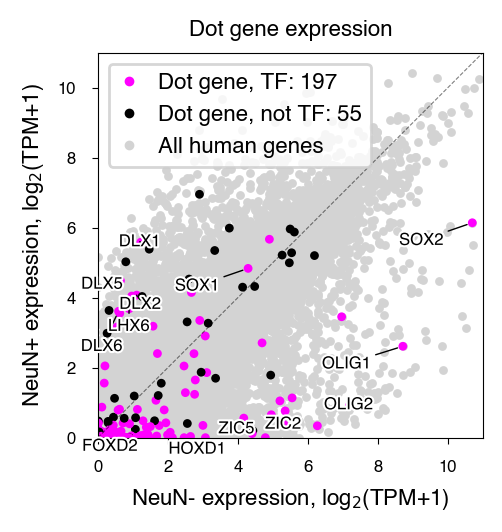

In [22]:
# count groups
n_grp = {grp: hand_pc_cnts.loc[hand_pc_cnts['Is TF?'] == grp].shape[0]
         for grp in ['Yes', "No"]}
tf_col = 'magenta'

fig, ax = plt.subplots(1, 1, dpi=200, figsize=[2.5, 2.5])
sns.scatterplot(data=riz_cnts.loc[riz_cnts['gene.type'] == 'protein_coding'], 
                x='log2TPM_NeuNminus', y='log2TPM_NeuNplus', color='lightgrey', linewidth=0, s=10, 
                ax=ax, label='All genes', rasterized=True)
sns.scatterplot(data=hand_pc_cnts, x='log2TPM_NeuNminus', y='log2TPM_NeuNplus', hue='Is TF?', linewidth=0, 
                palette={"Yes": tf_col, 'No': 'black'}, s=10, alpha=1, ax=ax)

# annotate some dots
ann_list = ['SOX2', 'OLIG1', 'OLIG2', 'HOXD1', 'SOX1', 'DLX1', 'DLX2', 'DLX5', 'DLX6', 'ZIC2', 
            'ZIC5', 'FOXD2', 'LHX6']
texts = []
for idx, row in hand_pc_cnts[['gene.name', 'log2TPM_NeuNplus', 'log2TPM_NeuNminus']].iterrows():
    if row['gene.name'] in ann_list:
        texts.append(
            plt.text(row['log2TPM_NeuNminus'], row['log2TPM_NeuNplus'], 
                     row['gene.name'], 
                     ha='right', 
                     va='top', fontsize=6,
                     path_effects=[pe.withStroke(linewidth=1.5, foreground="white")])
        )
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

# make legend
ms = 5
legend_elements = [
    Line2D([0], [0], marker='.', label=f"Dot gene, TF: {n_grp['Yes']}", color=tf_col, alpha=1, 
           markerfacecolor=tf_col, markersize=ms, linestyle='None'),
    Line2D([0], [0], marker='.', label=f"Dot gene, not TF: {n_grp['No']}", color='black', alpha=1, 
           markerfacecolor='black', markersize=ms, linestyle='None'),
    Line2D([0], [0], marker='.', label='All human genes', color='lightgrey', 
           markerfacecolor='lightgrey', markersize=ms, linestyle='None'),
]
ax.legend(handles=legend_elements, loc='upper left', handlelength=1, fontsize=8)
        
plt.plot([0, 11], [0, 11], 'k--', alpha=0.5)
plt.xlim([0, 11])
plt.ylim([0, 11])
plt.title('Dot gene expression')
plt.xlabel(r'NeuN- expression, log$_{2}$(TPM+1)')
plt.ylabel(r'NeuN+ expression, log$_{2}$(TPM+1)')
ax.set_aspect('equal', 'box')

## Compute expected and its variance for scaling plot

In [23]:
# Load hi-c matrices
res = 100_000

clrs = {ct: cooler.Cooler(clr_path[ct] + f'::resolutions/{res}') 
        for ct in ('NeuN+', 'NeuN-')}

In [24]:
# Compute expected
cvd_sm = {}
cvd_sm_agg = {}
for ct in ['NeuN+', 'NeuN-']:
    print(ct)
    cvd_sm[ct] = cooltools.expected_cis(clrs[ct], smooth=True, aggregate_smoothed=True, nproc=10)
    cvd_sm[ct]['s_bp'] = cvd_sm[ct]['dist'] * res
    
    # convert per-chromosome expected values to whole-genome
    cvd_sm_agg[ct] = utils.group_expected(cvd_sm[ct], smooth=True)
    cvd_sm_agg[ct]['s_bp'] = cvd_sm_agg[ct].index * res
    cvd_sm_agg[ct].loc[[0, 1], 'balanced.avg.smoothed.agg'] = np.nan # drop diags

    # normalize so that scaling starts from 1
    cvd_sm_agg[ct].loc[:, 'balanced.avg.smoothed.agg.norm'] = \
        cvd_sm_agg[ct]['balanced.avg.smoothed.agg'] / \
        cvd_sm_agg[ct].loc[2, 'balanced.avg.smoothed.agg']

NeuN+
NeuN-


In [25]:
# Compute std for expected
cvd_var_sm = {}
for ct in ['NeuN+', 'NeuN-']:
    print(ct)
    cvd_var_sm[ct] = utils.expected_std(clrs[ct], cvd_sm_agg[ct])

NeuN+
NeuN-


In [26]:
# Normalize and smooth std
for ct in ['NeuN+', 'NeuN-']:
    if 'std' in cvd_sm_agg[ct].columns:
        cvd_sm_agg[ct] = cvd_sm_agg[ct].drop(columns='std')
    cvd_sm_agg[ct] = cvd_sm_agg[ct].join(cvd_var_sm[ct])
    cvd_sm_agg[ct].loc[:, 'std.norm'] = \
        cvd_sm_agg[ct]['std'] / cvd_sm_agg[ct].loc[2, 'balanced.avg.smoothed.agg']

    cvd_sm_agg[ct]['std.norm.smooth'] = log_smooth(
        cvd_sm_agg[ct].index.values.astype(np.float64),
        cvd_sm_agg[ct]['std.norm'].values.astype(np.float64),
        sigma_log10=0.075,
        window_sigma=2, 
        points_per_sigma=80
    )
    cvd_sm_agg[ct].loc[[0, 1], 'std.norm.smooth'] = np.nan
    
cvd_sm_agg[ct].head()

,n_valid.agg,balanced.sum.agg,balanced.avg.smoothed.agg,balanced.avg.agg,s_bp,balanced.avg.smoothed.agg.norm,std,std.norm,std.norm.smooth
dist,,,,,,,,,
0,26908,0.000000,NaN,0.000000,0,NaN,0.195436,15.061226,NaN
1,26398,0.000000,NaN,0.000000,100000,NaN,0.028307,2.181449,NaN
2,26158,359.047026,0.012976,0.013726,200000,1.000000,0.005769,0.444600,0.444600
3,26039,269.103908,0.010061,0.010335,300000,0.775363,0.004299,0.331285,0.317799
4,25951,218.080231,0.008182,0.008404,400000,0.630543,0.003423,0.263789,0.261993


In [27]:
# Make interactions out of polycomb anchors
# Convert peak coordinates to corresponding hic bins
hand_df_bins = utils.regs_to_bins(dot_anch, res, mode='all')\
    .drop_duplicates(['chrom', 'start', 'end'])
pair_sites = bf.pair_by_distance(hand_df_bins, min_sep=200_000, 
                                 max_sep=int(1e10), suffixes=('1', '2'))

for ct in ['NeuN+', 'NeuN-']:
    print(ct)
    pair_sites = utils.obs_for_bin_pairs(pair_sites, clrs[ct], f'obs_{ct}')

pair_sites['dist'] = (pair_sites['start2'] - pair_sites['start1']).abs()
pair_sites.head()

NeuN+
NeuN-


,chrom1,start1,end1,genes1,idx1,chrom2,start2,end2,genes2,idx2,obs_NeuN+,obs_NeuN-,dist
0,chr18,800000,900000,"ADCYAP1,AP000894.2",91,chr18,3400000,3500000,TGIF1,92,0.003799,0.002114,2600000
1,chr18,800000,900000,"ADCYAP1,AP000894.2",91,chr18,22100000,22200000,"GATA6,GATA6-AS1",93,0.000864,0.000617,21300000
2,chr18,3400000,3500000,TGIF1,92,chr18,22100000,22200000,"GATA6,GATA6-AS1",93,0.001466,0.000563,18700000
3,chr18,800000,900000,"ADCYAP1,AP000894.2",91,chr18,47200000,47300000,SKOR2,94,0.000397,0.000260,46400000
4,chr18,3400000,3500000,TGIF1,92,chr18,47200000,47300000,SKOR2,94,0.000890,0.000255,43800000


In [28]:
# Calculate observed over expected
for ct in ['NeuN+', 'NeuN-']:
    cvd_obs_exp = cvd_sm[ct][['region1', 's_bp', 'balanced.avg.smoothed']].copy(deep=True)
    cvd_obs_exp.set_index(['region1', 's_bp'], inplace=True)

    pair_sites = pair_sites.merge(cvd_obs_exp, left_on=['chrom1', 'dist'], 
                                  right_index=True, how='inner')\
                           .rename(columns={'balanced.avg.smoothed': f'balanced.avg.smoothed_{ct}'})
    pair_sites[f'obs_exp_{ct}'] = pair_sites[f'obs_{ct}'] / pair_sites[f'balanced.avg.smoothed_{ct}']

pair_sites.head()

,chrom1,start1,end1,genes1,idx1,chrom2,start2,end2,genes2,idx2,obs_NeuN+,obs_NeuN-,dist,balanced.avg.smoothed_NeuN+,obs_exp_NeuN+,balanced.avg.smoothed_NeuN-,obs_exp_NeuN-
0,chr18,800000,900000,"ADCYAP1,AP000894.2",91,chr18,3400000,3500000,TGIF1,92,0.003799,0.002114,2600000,0.002660,1.428379,0.001721,1.228955
1,chr18,800000,900000,"ADCYAP1,AP000894.2",91,chr18,22100000,22200000,"GATA6,GATA6-AS1",93,0.000864,0.000617,21300000,0.000239,3.610956,0.000400,1.542764
2,chr18,3400000,3500000,TGIF1,92,chr18,22100000,22200000,"GATA6,GATA6-AS1",93,0.001466,0.000563,18700000,0.000253,5.795274,0.000419,1.344417
3,chr18,800000,900000,"ADCYAP1,AP000894.2",91,chr18,47200000,47300000,SKOR2,94,0.000397,0.000260,46400000,0.000201,1.971763,0.000304,0.856394
4,chr18,3400000,3500000,TGIF1,92,chr18,47200000,47300000,SKOR2,94,0.000890,0.000255,43800000,0.000200,4.443224,0.000311,0.820679


## Plot: polycomb dot scaling (Figure 4C)

In [29]:
# Read filtered fithic data
fithic = {
    ct: pd.read_table(fithic_path[ct]) for ct in ['NeuN+', 'NeuN-']
}
fithic['NeuN-'].head()

,chrom1,start1,end1,chrom2,start2,end2,q-value
0,chr1,18600000,18700000,chr1,47700000,47800000,1.060688e-03
1,chr1,47400000,47500000,chr1,47700000,47800000,1.006261e-105
2,chr1,18600000,18700000,chr17,49000000,49100000,1.192228e-02
3,chr15,76300000,76400000,chr17,49000000,49100000,1.117488e-02
4,chr17,35400000,35500000,chr17,49000000,49100000,6.413910e-04


(951,)
[-0.68692527]
(951,)
(951,)
[-0.80162709]
(951,)


Text(0.5, 0, '')

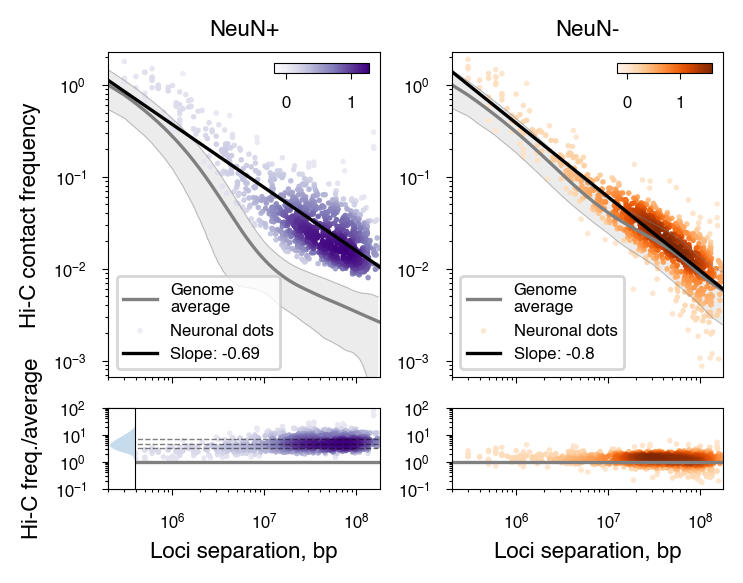

In [30]:
# Analyse polycomb scaling
fig, axs = plt.subplots(2, 2, dpi=200, figsize=[3.6, 2.8], 
                        layout="constrained", 
                        gridspec_kw={'height_ratios': [4, 1]}, sharex='col')

cmaps = {"NeuN+": 'Purples', 'NeuN-': 'Oranges'}
xlims = [2e5, 1.8e8]

for i, ct in enumerate(['NeuN+', 'NeuN-']):
    
    ###########
    # Observed
    ###########
    ax = axs[0, i]
    
    # Whole-genome expected
    ax.loglog(
        cvd_sm_agg[ct]['s_bp'],
        cvd_sm_agg[ct]['balanced.avg.smoothed.agg.norm'],
        color='grey', label='Genome\naverage', linewidth=1.2
    )
    
    # Whole-genome standard deviation
    lo_std = cvd_sm_agg[ct]['balanced.avg.smoothed.agg.norm'] - cvd_sm_agg[ct]['std.norm.smooth']
    hi_std = cvd_sm_agg[ct]['balanced.avg.smoothed.agg.norm'] + cvd_sm_agg[ct]['std.norm.smooth']
    ax.plot(cvd_sm_agg[ct]['s_bp'], lo_std, c='grey', alpha=0.5)
    ax.plot(cvd_sm_agg[ct]['s_bp'], hi_std, c='grey', alpha=0.5)
    ax.fill_between(cvd_sm_agg[ct]['s_bp'], lo_std, hi_std, alpha=0.15, 
                        facecolor='grey')
    
    # Neuronal dots
    df = pair_sites.loc[(pair_sites[f'obs_NeuN+'] > 0) &
                        (pair_sites[f'obs_NeuN-'] > 0)]
    # keep pairs with significant Hi-C signal (fithic)
    df = df.merge(fithic['NeuN+'].drop(columns='q-value'), how='inner', 
                  on=['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2'])
    df[f'obs_{ct}'] = df[f'obs_{ct}'] / cvd_sm[ct]['balanced.avg.smoothed.agg'].values[2]
    # Calculate the point density
    xy = np.vstack([np.log10(df['dist']), np.log10(df[f'obs_{ct}'])])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = df['dist'].values[idx], df[f'obs_{ct}'].values[idx], z[idx]
    print(y.shape)
    p = ax.scatter(x, y, c=z, s=4, cmap=cmaps[ct], 
                   norm=matplotlib.colors.Normalize(vmin=z.min()-0.2, vmax=z.max()),
                   edgecolors='grey', linewidths=0, label="Neuronal dots", rasterized=True)

    # Colorbar
    cbaxes = inset_axes(ax, width="35%", height="3%", loc='upper right') 
    cbar = plt.colorbar(p, cax=cbaxes, orientation='horizontal')
    cbaxes.tick_params(axis='both', length=2)

    # Linear regression
    Xy = df[['dist', f'obs_{ct}']].dropna().values
    X, y = Xy[:, 0].reshape(-1, 1), Xy[:, 1]
    reg = LinearRegression().fit(np.log10(X), np.log10(y))
    print(reg.coef_)
    X_plot = xlims
    y_plot = 10 ** (np.log10(X_plot) * reg.coef_ + reg.intercept_)
    ax.plot(X_plot, y_plot, 'k-', alpha=1, linewidth=1.2, 
            label=f"Slope: {round(reg.coef_[0], 2)}")
    
    ax.set_aspect('equal', adjustable='datalim')
    ax.set_xlim(xlims)
    ax.set_ylim([5e-4, 3])
    ax.set_title(ct)
    ax.legend(loc='lower left', fontsize=6)
    
    ###########
    # Obs / exp
    ###########
    ax = axs[1, i]
    
    # Neuronal dots
    # Calculate the point density
    xy = np.vstack([np.log10(df['dist']), np.log10(df[f'obs_exp_{ct}'])])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = df['dist'].values[idx], df[f'obs_exp_{ct}'].values[idx], z[idx]
    print(y.shape)
    ax.scatter(x, y, c=z, s=4, cmap=cmaps[ct], 
               norm=matplotlib.colors.Normalize(vmin=z.min()-0.2, vmax=z.max()),
               edgecolors='grey', linewidths=0, label="Neuronal dots", zorder=1, 
               rasterized=True)
    
    # Expected
    ax.plot(xlims, [1, 1], color='grey', label='Genome average', linewidth=1.2, zorder=2)
    
    ax.set_yscale('log')
    ax.set_ylim([1e-1, 1e2])
    ax.set_xlabel('Loci separation, bp')

    # Quantiles for NeuN+
    if ct == 'NeuN+':
        quant = df['obs_exp_NeuN+'].quantile([0, 0.25, 0.5, 0.75, 1]).values
        for j in range(1, 4):
            ax.plot(xlims, [quant[j], quant[j]], 
                     color='k', 
                     linestyle='--', 
                     alpha=0.5, linewidth=0.5, zorder=1)
            

axs[0, 0].set_ylabel('Hi-C contact frequency')
axs[1, 0].set_ylabel('Hi-C freq./average', fontsize=8)

# Plot histogram
axin1 = axs[1, 0].inset_axes([0, 0, 0.1, 1])
sns.kdeplot(data=df, y='obs_exp_NeuN+', ax=axin1, fill=True,
            log_scale=(False, 10), linewidth=0)
axin1.set_ylim([1e-1, 1e2])
axin1.invert_xaxis()
axin1.set_yticks([])
axin1.set_xticks([])
axin1.set_ylabel('')
axin1.set_xlabel('')

## Plot: average LaminB1 profile (Figure 4F)

In [31]:
chromsizes = bf.fetch_chromsizes('hg38')
chroms_view = pd.DataFrame(data={
    'chrom': chromsizes.index,
    'start': [0] * chromsizes.shape[0],
    'end': chromsizes.values,
    'name': chromsizes.index
})

In [32]:
pair_sites_lam = pair_sites.dropna(subset=['obs_NeuN+']).copy(deep=True)
# keep pairs with significant Hi-C signal (fithic)
pair_sites_lam = pair_sites_lam.merge(
    fithic['NeuN+'].drop(columns='q-value'), how='inner', 
    on=['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
)
pair_sites_lam['q_NeuN+'] = pd.qcut(pair_sites_lam['obs_exp_NeuN+'], 4, 
                                    labels=['Q1', 'Q2', 'Q3', 'Q4'])
pair_sites_lam['q_dist'] = pd.qcut(pair_sites_lam['dist'], 4, 
                                    labels=['Q1', 'Q2', 'Q3', 'Q4'])
pair_sites_lam['chrom'] = pair_sites_lam['chrom1']
pair_sites_lam['start'] = pair_sites_lam['start1']
pair_sites_lam['end'] = pair_sites_lam['end2']
pair_sites_lam['length'] = pair_sites_lam['end'] - pair_sites_lam['start']
pair_sites_lam['start'] -= pair_sites_lam['length'] // 2
pair_sites_lam['end'] += pair_sites_lam['length'] // 2

pair_sites_lam = pair_sites_lam.merge(
    chroms_view.rename(columns={'end': 'chrom_end'})[['chrom', 'chrom_end']],
    on='chrom'
)
pair_sites_lam = pair_sites_lam.loc[(pair_sites_lam['start'] >= 0) &
                                    (pair_sites_lam['end'] <= pair_sites_lam['chrom_end'])]


pair_sites_lam.head()

,chrom1,start1,end1,genes1,idx1,chrom2,start2,end2,genes2,idx2,...,obs_exp_NeuN+,balanced.avg.smoothed_NeuN-,obs_exp_NeuN-,q_NeuN+,q_dist,chrom,start,end,length,chrom_end
5,chr18,22100000,22200000,"GATA6,GATA6-AS1",93,chr18,47200000,47300000,SKOR2,94,...,9.279247,0.000381,1.109570,Q4,Q2,chr18,9500000,59900000,25200000,80373285
8,chr18,22100000,22200000,"GATA6,GATA6-AS1",93,chr18,57400000,57500000,"ONECUT2,AC090340.1",95,...,7.679961,0.000342,0.794415,Q4,Q3,chr18,4400000,75200000,35400000,80373285
9,chr18,47200000,47300000,SKOR2,94,chr18,57400000,57500000,"ONECUT2,AC090340.1",95,...,8.991953,0.000587,1.664838,Q4,Q1,chr18,42050000,62650000,10300000,80373285
10,chr12,53900000,54000000,"HOXC4,HOXC5,HOXC8,HOXC9,HOXC10,HOXC11,HOXC12,H...",48,chr12,85200000,85300000,ALX1,49,...,4.700721,0.000236,0.979992,Q3,Q2,chr12,38200000,101000000,31400000,133275309
11,chr12,54000000,54100000,"HOXC4,HOXC5,HOXC8,HOXC9,HOXC10,HOXC11,HOXC12,H...",48,chr12,85200000,85300000,ALX1,49,...,4.967844,0.000236,1.383255,Q3,Q2,chr12,38350000,100950000,31300000,133275309


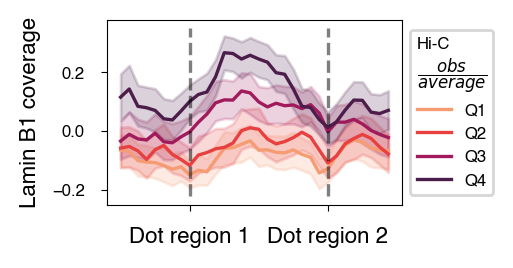

In [33]:
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(1.9, 1.2))

# get genome average coverage of lamin B
lam_pk = pd.read_table(lamin_peak_path,
                       names=['chrom', 'start', 'end'], usecols=[0, 1, 2])
lam_pk['length'] = lam_pk['end'] - lam_pk['start']
no_lam = bf.complement(lam_pk, view_df=chroms_view)
no_lam['length'] = no_lam['end'] - no_lam['start']

s_lam_sum = bbi.stackup(lamin_profile_path, lam_pk['chrom'], lam_pk['start'], 
                        lam_pk['end'], bins=1, summary='sum')
s_lam_av = np.sum(s_lam_sum) / np.sum(lam_pk['length'].values)

s_nolam_sum = bbi.stackup(lamin_profile_path, no_lam['chrom'], no_lam['start'], 
                          no_lam['end'], bins=1, summary='sum')
s_nolam_av = np.sum(s_nolam_sum) / np.sum(no_lam['length'].values)

# Plot laminB coverage
lam_colors = sns.color_palette("rocket_r", n_colors=4)
for j, ct in enumerate(['NeuN+']): 
    for i, q in enumerate(sorted(pair_sites_lam['q_NeuN+'].unique())):
        df = pair_sites_lam.loc[pair_sites_lam['q_NeuN+'] == q]

        s = bbi.stackup(lamin_profile_path, 
                        df['chrom'], df['start'], df['end'], bins=32)
        s_df = pd.DataFrame(data=s)
        sns.lineplot(data=s_df.melt(), x='variable', y='value', label=q, ax=ax, 
                     color=lam_colors[i], alpha=1, linewidth=1.2)

    ymin, ymax = ax.get_ylim()
    ax.plot([8, 8], [ymin, ymax], 'k--', alpha=0.5, linewidth=1.2)
    ax.plot([24, 24], [ymin, ymax], 'k--', alpha=0.5, linewidth=1.2)
    ax.legend(loc='center left', bbox_to_anchor=[1, 0.5],
              title='Hi-C\n' r'$\dfrac{obs}{average}$',  
              title_fontsize=6, fontsize=6)
    ax.set_xticks([8, 24], ['Dot region 1', 'Dot region 2'], fontsize=8)
    ax.set_xlabel('')
    ax.set_ylabel('Lamin B1 coverage')

## Analyse fithic network

In [34]:
# Overlap pairs of anchors with fithic, include trans contacts
netw = {}
hand_df_bins = utils.regs_to_bins(dot_anch, res, mode='all')\
        .drop_duplicates(['chrom', 'start', 'end'])

for ct in ['NeuN+', 'NeuN-']:
    netw[ct] = fithic[ct].merge(
        hand_df_bins[['chrom', 'start', 'end']], 
        left_on=['chrom1', 'start1', 'end1'],
        right_on=['chrom', 'start', 'end'], how='inner'
    ).drop(columns=['chrom', 'start', 'end'])
    
    netw[ct] = netw[ct].merge(
        hand_df_bins[['chrom', 'start', 'end']], 
        left_on=['chrom2', 'start2', 'end2'],
        right_on=['chrom', 'start', 'end'], how='inner'
    ).drop(columns=['chrom', 'start', 'end'])
    
netw[ct].head()

,chrom1,start1,end1,chrom2,start2,end2,q-value
0,chr1,18600000,18700000,chr1,47700000,47800000,1.060688e-03
1,chr1,47400000,47500000,chr1,47700000,47800000,1.006261e-105
2,chr1,18600000,18700000,chr17,49000000,49100000,1.192228e-02
3,chr15,76300000,76400000,chr17,49000000,49100000,1.117488e-02
4,chr17,35400000,35500000,chr17,49000000,49100000,6.413910e-04


In [35]:
# Get nodes from edge df
netw_nod = {}

for ct in ['NeuN+', 'NeuN-']:    
    netw[ct].loc[:, 'ucsc1'] = netw[ct]['chrom1'] + ':' + netw[ct]['start1'].astype(str) + '-' + \
        netw[ct]['end1'].astype(str)
    netw[ct].loc[:, 'ucsc2'] = netw[ct]['chrom2'] + ':' + netw[ct]['start2'].astype(str) + '-' + \
        netw[ct]['end2'].astype(str)

    netw_nod[ct] = utils.bedpe_to_bed(netw[ct])

netw[ct].head()

,chrom1,start1,end1,chrom2,start2,end2,q-value,ucsc1,ucsc2
0,chr1,18600000,18700000,chr1,47700000,47800000,1.060688e-03,chr1:18600000-18700000,chr1:47700000-47800000
1,chr1,47400000,47500000,chr1,47700000,47800000,1.006261e-105,chr1:47400000-47500000,chr1:47700000-47800000
2,chr1,18600000,18700000,chr17,49000000,49100000,1.192228e-02,chr1:18600000-18700000,chr17:49000000-49100000
3,chr15,76300000,76400000,chr17,49000000,49100000,1.117488e-02,chr15:76300000-76400000,chr17:49000000-49100000
4,chr17,35400000,35500000,chr17,49000000,49100000,6.413910e-04,chr17:35400000-35500000,chr17:49000000-49100000


In [36]:
# Make graph
G_fh = {}
for ct in ['NeuN+', 'NeuN-']:
    G_fh[ct] = nx.from_pandas_edgelist(
                  netw[ct], 
                  source='ucsc1', 
                  target='ucsc2',
               )

    # add chrom as node attribute
    for idx, row in netw_nod[ct].iterrows():
        G_fh[ct].nodes[f"{row['chrom']}:{row['start']}-{row['end']}"]['chrom'] = row['chrom']

### Plot number of bins involved in cliques (Figure 4E)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


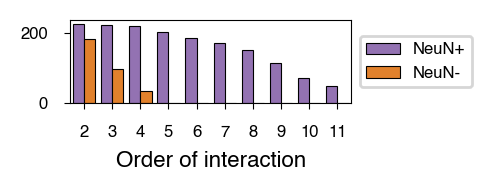

In [37]:
N_max = 12
n_inter = np.arange(2, N_max)
inter_size = np.zeros((2, N_max - 2))

for i, ct in enumerate(["NeuN+", 'NeuN-']):
    inter_lst = [set() for i in range(N_max-2)]

    for n in n_inter:
        for clq in nx.enumerate_all_cliques(G_fh[ct]):
            if len(clq) == n:
                inter_lst[n-2] = inter_lst[n-2].union(clq)
                
    inter_size[i, :] = [len(x) for x in inter_lst]

df = pd.DataFrame(data=inter_size, columns=n_inter)
df['Cell type'] = ["NeuN+", 'NeuN-']
df_melt = df.melt(id_vars='Cell type', var_name='order')

fig, axs = plt.subplots(1, 1, dpi=200, figsize=(2.5, 1))

sns.barplot(data=df_melt, x='order', y='value', hue='Cell type', ax=axs,
            palette=colors, linewidth=0.4, edgecolor='k')
axs.set_ylabel('')
axs.set_xlabel('Order of interaction')
axs.legend(loc='center left', bbox_to_anchor=[1, 0.5], fontsize=6)
plt.tight_layout()

### Plot: circos (Figure 4D)

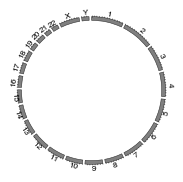

In [38]:
Garc    = pycircos.Garc
Gcircle = pycircos.Gcircle

#Set chromosomes
circle = Gcircle(figsize=(1.5, 1.5)) 
for chrom, length in chromsizes.items():
    if chrom == 'chrM':
        continue
    name   = chrom.lstrip('chr')
    length = int(length) 
    arc    = Garc(arc_id=name, size=length, interspace=2, raxis_range=(935,985), 
                  labelposition=80, label_visible=True, facecolor='gray', labelsize=6,
                  linewidth=0.4)
    circle.add_garc(arc) 

circle.set_garcs() 
for arc_id in circle.garc_dict:
    circle.tickplot(arc_id, raxis_range=(985,1000), tickinterval=20000000, ticklabels=None,
                    tickwidth=0.4)

In [39]:
# linkplot
# Works for one cell-type at a time
ct = 'NeuN-'

values_all   = [] 
arcdata_dict = collections.defaultdict(dict)
fithic_circ = {
    ct: pd.read_table(fithic_path[ct]) for ct in ['NeuN+', 'NeuN-']
}
for idx, row in fithic_circ[ct].iterrows():
    if row['chrom1'] == row['chrom2']: # same chromosomes
        continue
    name1  = row['chrom1'].lstrip('chr')    
    name2  = row['chrom2'].lstrip('chr')     
    source = (name1, row['start1'], row['end1'], 915)
    destination = (name2, row['start2'], row['end2'], 915)
    circle.chord_plot(source, destination, facecolor=matplotlib.colors.to_rgba('orange', alpha=0.2), 
                      edgecolor=matplotlib.colors.to_rgba('orange', alpha=0.2), linewidth=0.4)

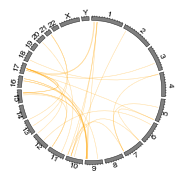

In [40]:
circle.figure

In [41]:
# circle.save(f'circos.{ct}.hand_polycomb')